In [2]:
#####
#####  RUN NOTES
#####

# Eating disorders Montecatini, HDDM analysis
# Controls, at-risk participants, and patients split by diagnostic category. 
# Written by Corrado Caudek

#####
#####  PURPOSE
#####

# The present script is used for the HDDMrl analysis of performance in the PRL 
# task with food and neutral images.
# With this script, the HDDMrl parameters are estimated separately for each of 
# 6 groups: 
# - AN     anorexia, 
# - AN-R   anorexia in remission, 
# - BN     bulimia, 
# - BN-R   bulimia in remission, 
# - RI     university students at risk according to the EAT-26,
# - HC     university students not at risk according to the EAT-26.

import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-06-09 17:16:31


In [3]:
from platform import python_version
print('The current Python version is', python_version())

The current Python version is 3.6.10


In [4]:
# MODULE IMPORTS ----

# warning settings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data management
import pandas as pd
import numpy as np
import pickle

from patsy import dmatrix
from kabuki.analyze import gelman_rubin
from kabuki.utils import concat_models
import pathlib

# Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Stats functionality
from statsmodels.distributions.empirical_distribution import ECDF

# HDDM
import hddm
print(hddm.__version__)

# Get around a problem with saving regression outputs in Python 3
def savePatch(self, fname):
    import pickle
    with open(fname, 'wb') as f:
        pickle.dump(self, f)
hddm.HDDM.savePatch = savePatch

0.8.0


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [5]:
pwd

'/Users/corrado/_repositories/eating_disorders_montecatini/scripts/python/PRL/classification'

In [6]:
#####
#####  READ DATA
#####

data = hddm.load_csv('hddm_input_20220603v2.csv') 

In [9]:
data_an = data[data.diag_cat == 'AN']
print('There are %d participants' %data_an['subj_idx'].nunique())

There are 38 participants


In [16]:
data_hc = data[data.diag_cat == 'HC']
print('There are %d participants' %data_hc['subj_idx'].nunique())

There are 220 participants


There are 311 participants


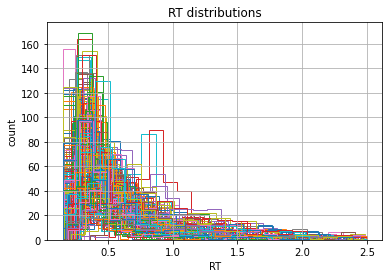

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
plt.savefig('plot_hist_rt_patients.pdf')

print('There are %d participants' %data['subj_idx'].nunique())

In [9]:
data.head()

,subj_idx,response,stim,rt,trial,split_by,feedback,diag_cat,subj_code,q_init
0,1,0,food,0.979,1,0,0,AN,ca_po_2002_05_25_700_f,0.5
1,1,0,neutral,1.553,1,1,0,AN,ca_po_2002_05_25_700_f,0.5
2,1,1,food,1.939,2,0,0,AN,ca_po_2002_05_25_700_f,0.5
3,1,1,neutral,0.350,2,1,1,AN,ca_po_2002_05_25_700_f,0.5
4,1,0,food,0.768,3,0,0,AN,ca_po_2002_05_25_700_f,0.5


In [10]:
data.groupby(['diag_cat', 'stim']).agg({'feedback': 'mean'})

feedback
diag_cat stim             
AN       food     0.531250
         neutral  0.550714
AN_R     food     0.521528
         neutral  0.535625
BN       food     0.537500
         neutral  0.541250
BN_R     food     0.546250
         neutral  0.523750
HC       food     0.543810
         neutral  0.544511
RI       food     0.543269
         neutral  0.568155

In [11]:
data.groupby(['diag_cat', 'stim']).agg({'rt': 'mean'})

rt
diag_cat stim             
AN       food     0.676011
         neutral  0.592044
AN_R     food     0.708483
         neutral  0.569473
BN       food     0.680351
         neutral  0.531536
BN_R     food     0.658710
         neutral  0.592061
HC       food     0.598443
         neutral  0.557056
RI       food     0.602302
         neutral  0.522246

In [12]:
df = data[data.diag_cat == 'AN']
df.describe()

,subj_idx,response,rt,trial,split_by,feedback,q_init
count,11360.000000,11360.000000,11360.000000,11360.000000,11360.000000,11360.000000,11360.0
mean,38.633803,0.465317,0.634619,80.500000,0.492958,0.540845,0.5
std,46.814915,0.498818,0.405018,46.189152,0.499972,0.498351,0.0
min,1.000000,0.000000,0.150000,1.000000,0.000000,0.000000,0.5
25%,14.000000,0.000000,0.351000,40.750000,0.000000,0.000000,0.5
50%,32.000000,0.000000,0.512000,80.500000,0.000000,1.000000,0.5
75%,48.000000,1.000000,0.796000,120.250000,1.000000,1.000000,0.5
max,295.000000,1.000000,2.488000,160.000000,1.000000,1.000000,0.5


In [13]:
df1 = data[data.diag_cat == 'HC']
df1.describe()

,subj_idx,response,rt,trial,split_by,feedback,q_init
count,64640.000000,64640.000000,64640.000000,64640.000000,64640.000000,64640.000000,64640.0
mean,186.215347,0.473484,0.578262,80.500000,0.487624,0.544152,0.5
std,69.949749,0.499300,0.383188,46.187477,0.499851,0.498051,0.0
min,63.000000,0.000000,0.150000,1.000000,0.000000,0.000000,0.5
25%,127.500000,0.000000,0.331750,40.750000,0.000000,0.000000,0.5
50%,188.000000,0.000000,0.449000,80.500000,0.000000,1.000000,0.5
75%,247.000000,1.000000,0.685000,120.250000,1.000000,1.000000,0.5
max,311.000000,1.000000,2.499000,160.000000,1.000000,1.000000,0.5


In [17]:
#####
#####  RUN MODEL mod1
#####

# a = decision threshold
# v = drift rate
# t = non-decision time 
# alpha = learning rate

mod_hc = hddm.HDDMrl(
  data_hc,
  bias = True,
  depends_on = {
      'a':['stim'],
      'v':['stim'],
      't':['stim'],
      'alpha':['stim'],
      'pos_alpha':['stim']
     },
  dual = True, # separate learning rates for pos/neg feedbacks
  p_outlier = 0.05
)

In [18]:
mod_hc.find_starting_values()

/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [19]:
mod_hc.sample(2500, burn=500, dbname='traces.db', db='pickle')

 [-----------------100%-----------------] 2501 of 2500 complete in 5501.4 sec

In [ ]:
alpha_an_f,  alpha_an_n, alpha_anr_f, alpha_anr_n, alpha_bn_f,  alpha_bn_n, alpha_bnr_f, alpha_bnr_n, alpha_hc_f,  alpha_hc_n, alpha_ri_f,  alpha_ri_n = mod1.nodes_db.node[[
    'alpha(AN.food)',   'alpha(AN.neutral)', 
    'alpha(AN_R.food)', 'alpha(AN_R.neutral)', 
    'alpha(BN.food)',   'alpha(BN.neutral)', 
    'alpha(BN_R.food)', 'alpha(BN_R.neutral)', 
    'alpha(HC.food)',   'alpha(HC.neutral)', 
    'alpha(RI.food)',   'alpha(RI.neutral)', 
    ]]

In [ ]:
pos_alpha_an_f,  pos_alpha_an_n, pos_alpha_anr_f, pos_alpha_anr_n, pos_alpha_bn_f,  pos_alpha_bn_n, pos_alpha_bnr_f, pos_alpha_bnr_n, pos_alpha_hc_f,  pos_alpha_hc_n, pos_alpha_ri_f,  pos_alpha_ri_n = mod1.nodes_db.node[[
    'pos_alpha(AN.food)',   'pos_alpha(AN.neutral)', 
    'pos_alpha(AN_R.food)', 'pos_alpha(AN_R.neutral)', 
    'pos_alpha(BN.food)',   'pos_alpha(BN.neutral)', 
    'pos_alpha(BN_R.food)', 'pos_alpha(BN_R.neutral)', 
    'pos_alpha(HC.food)',   'pos_alpha(HC.neutral)', 
    'pos_alpha(RI.food)',   'pos_alpha(RI.neutral)', 
    ]]


In [ ]:
alpha_an_res, alpha_an, alpha_an_r, alpha_ri, alpha_bn_res, alpha_bn, alpha_bn_r = mod1.nodes_db.node[['alpha(AN-RES)', 'alpha(AN)', 'alpha(AN-R)', 'alpha(AT_RISK)', 'alpha(BN-RES)',  'alpha(BN)', 'alpha(BN-R)']]
pos_alpha_an_res, pos_alpha_an, pos_alpha_an_r, pos_alpha_ri, pos_alpha_bn_res, pos_alpha_bn, pos_alpha_bn_r = mod1.nodes_db.node[['pos_alpha(AN-RES)', 'pos_alpha(AN)', 'pos_alpha(AN-R)', 'pos_alpha(AT_RISK)', 'pos_alpha(BN-RES)',  'pos_alpha(BN)', 'pos_alpha(BN-R)']]

In [ ]:
v_an_res, v_an, v_an_r, v_ri, v_bn_res, v_bn, v_bn_r = mod1.nodes_db.node[['v(AN-RES)', 'v(AN)', 'v(AN-R)', 'v(AT_RISK)', 'v(BN-RES)',  'v(BN)', 'v(BN-R)']]
t_an_res, t_an, t_an_r, t_ri, t_bn_res, t_bn, t_bn_r = mod1.nodes_db.node[['t(AN-RES)', 't(AN)', 't(AN-R)', 't(AT_RISK)', 't(BN-RES)',  't(BN)', 't(BN-R)']]
a_an_res, a_an, a_an_r, a_ri, a_bn_res, a_bn, a_bn_r = mod1.nodes_db.node[['a(AN-RES)', 'a(AN)', 'a(AN-R)', 'a(AT_RISK)', 'a(BN-RES)',  'a(BN)', 'a(BN-R)']]

In [ ]:
mod1.plot_posterior_predictive()


<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

# Alpha 

Text(0.5, 1.0, 'Posterior of negative alpha group means')

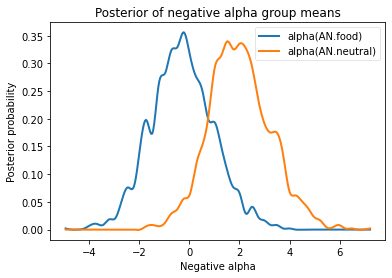

In [ ]:
hddm.analyze.plot_posterior_nodes([alpha_an_f, alpha_an_n])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha group means')

Text(0.5, 1.0, 'Posterior of negative alpha group means')

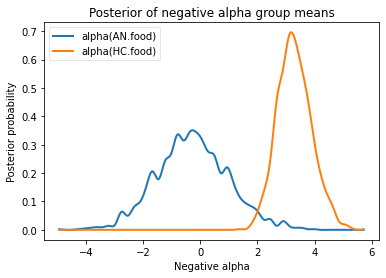

In [ ]:
hddm.analyze.plot_posterior_nodes([alpha_an_f, alpha_hc_f])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha group means')

Text(0.5, 1.0, 'Posterior of negative alpha group means')

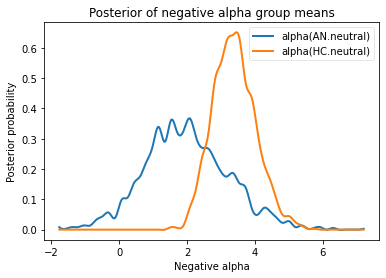

In [ ]:
hddm.analyze.plot_posterior_nodes([alpha_an_n, alpha_hc_n])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha group means')

Text(0.5, 1.0, 'Posterior of positive alpha group means')

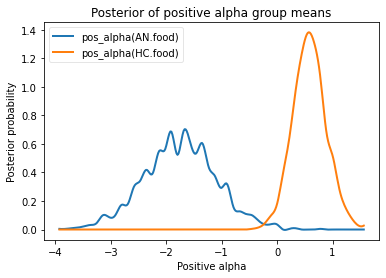

In [ ]:
hddm.analyze.plot_posterior_nodes([pos_alpha_an_f, pos_alpha_hc_f])
plt.xlabel('Positive alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of positive alpha group means')

Text(0.5, 1.0, 'Posterior of positive alpha group means')

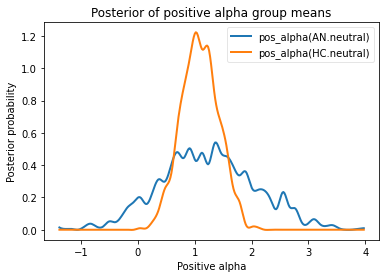

In [ ]:
hddm.analyze.plot_posterior_nodes([pos_alpha_an_n, pos_alpha_hc_n])
plt.xlabel('Positive alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of positive alpha group means')

In [ ]:
print("P(neg-alpha AN food > neg-alpha HC food) = ", (alpha_an_f.trace() > alpha_hc_f.trace()).mean())
print("P(neg-alpha AN neutral > neg-alpha HC neutral) = ", (alpha_an_n.trace() > alpha_hc_n.trace()).mean())
print("P(pos-alpha AN food > pos-alpha HC food) = ", (pos_alpha_an_f.trace() > pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha AN neutral > pos-alpha HC neutral) = ", (pos_alpha_an_n.trace() > pos_alpha_hc_n.trace()).mean())


P(neg-alpha AN food > neg-alpha HC food) =  0.0035
P(neg-alpha AN neutral > neg-alpha HC neutral) =  0.145
P(pos-alpha AN food > pos-alpha HC food) =  0.0
P(pos-alpha AN neutral > pos-alpha HC neutral) =  0.5665


In [ ]:
print("P(neg-alpha AN-R food > neg-alpha HC food) = ", (alpha_anr_f.trace() > alpha_hc_f.trace()).mean())
print("P(neg-alpha AN-R neutral > neg-alpha HC neutral) = ", (alpha_anr_n.trace() > alpha_hc_n.trace()).mean())
print("P(pos-alpha AN-R food > pos-alpha HC food) = ", (pos_alpha_anr_f.trace() > pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha AN-R neutral > pos-alpha HC neutral) = ", (pos_alpha_anr_n.trace() > pos_alpha_hc_n.trace()).mean())


P(neg-alpha AN-R food > neg-alpha HC food) =  0.4325
P(neg-alpha AN-R neutral > neg-alpha HC neutral) =  0.356
P(pos-alpha AN-R food > pos-alpha HC food) =  0.6135
P(pos-alpha AN-R neutral > pos-alpha HC neutral) =  0.3455


In [ ]:
print("P(neg-alpha BN food > neg-alpha HC food) = ", (alpha_bn_f.trace() > alpha_hc_f.trace()).mean())
print("P(neg-alpha BN neutral > neg-alpha HC neutral) = ", (alpha_bn_n.trace() > alpha_hc_n.trace()).mean())
print("P(pos-alpha BN food > pos-alpha HC food) = ", (pos_alpha_bn_f.trace() > pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha BN neutral > pos-alpha HC neutral) = ", (pos_alpha_bn_n.trace() > pos_alpha_hc_n.trace()).mean())


P(neg-alpha BN food > neg-alpha HC food) =  0.106
P(neg-alpha BN neutral > neg-alpha HC neutral) =  0.237
P(pos-alpha BN food > pos-alpha HC food) =  0.41
P(pos-alpha BN neutral > pos-alpha HC neutral) =  0.4475


In [ ]:
print("P(neg-alpha BN-R food > neg-alpha HC food) = ", (alpha_bnr_f.trace() > alpha_hc_f.trace()).mean())
print("P(neg-alpha BN-R neutral > neg-alpha HC neutral) = ", (alpha_bnr_n.trace() > alpha_hc_n.trace()).mean())
print("P(pos-alpha BN-R food > pos-alpha HC food) = ", (pos_alpha_bnr_f.trace() > pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha BN-R neutral > pos-alpha HC neutral) = ", (pos_alpha_bnr_n.trace() > pos_alpha_hc_n.trace()).mean())


P(neg-alpha BN-R food > neg-alpha HC food) =  0.408
P(neg-alpha BN-R neutral > neg-alpha HC neutral) =  0.3165
P(pos-alpha BN-R food > pos-alpha HC food) =  0.7155
P(pos-alpha BN-R neutral > pos-alpha HC neutral) =  0.4715


In [ ]:
print("P(neg-alpha RI food > neg-alpha HC food) = ", (alpha_ri_f.trace() > alpha_hc_f.trace()).mean())
print("P(neg-alpha RI neutral > neg-alpha HC neutral) = ", (alpha_ri_n.trace() > alpha_hc_n.trace()).mean())
print("P(pos-alpha RI food > pos-alpha HC food) = ", (pos_alpha_ri_f.trace() > pos_alpha_hc_f.trace()).mean())
print("P(pos-alpha RI neutral > pos-alpha HC neutral) = ", (pos_alpha_ri_n.trace() > pos_alpha_hc_n.trace()).mean())


P(neg-alpha RI food > neg-alpha HC food) =  0.365
P(neg-alpha RI neutral > neg-alpha HC neutral) =  0.1405
P(pos-alpha RI food > pos-alpha HC food) =  0.5585
P(pos-alpha RI neutral > pos-alpha HC neutral) =  0.731


# Drift rate

In [ ]:
v_an_f,  v_an_n, v_anr_f, v_anr_n, v_bn_f,  v_bn_n, v_bnr_f, v_bnr_n, v_hc_f,  v_hc_n, v_ri_f,  v_ri_n = mod1.nodes_db.node[[
    'v(AN.food)',   'v(AN.neutral)', 
    'v(AN_R.food)', 'v(AN_R.neutral)', 
    'v(BN.food)',   'v(BN.neutral)', 
    'v(BN_R.food)', 'v(BN_R.neutral)', 
    'v(HC.food)',   'v(HC.neutral)', 
    'v(RI.food)',   'v(RI.neutral)', 
    ]]

In [ ]:
print("P(v AN food > v HC food) = ", (v_an_f.trace() > v_hc_f.trace()).mean())
print("P(v AN neutral > v HC neutral) = ", (v_an_n.trace() > v_hc_n.trace()).mean())
print("P(v AN-R food > v HC food) = ", (v_anr_f.trace() > v_hc_f.trace()).mean())
print("P(v AN-R neutral > v HC neutral) = ", (v_anr_n.trace() > v_hc_n.trace()).mean())

P(v AN food > v HC food) =  0.5305
P(v AN neutral > v HC neutral) =  0.032
P(v AN-R food > v HC food) =  0.2435
P(v AN-R neutral > v HC neutral) =  0.581


In [ ]:
print("P(v BN food > v HC food) = ", (v_bn_f.trace() > v_hc_f.trace()).mean())
print("P(v BN neutral > v HC neutral) = ", (v_bn_n.trace() > v_hc_n.trace()).mean())
print("P(v BN-R food > v HC food) = ", (v_bnr_f.trace() > v_hc_f.trace()).mean())
print("P(v BN-R neutral > v HC neutral) = ", (v_bnr_n.trace() > v_hc_n.trace()).mean())

P(v BN food > v HC food) =  0.2465
P(v BN neutral > v HC neutral) =  0.863
P(v BN-R food > v HC food) =  0.2825
P(v BN-R neutral > v HC neutral) =  0.4125


In [ ]:
print("P(v RI food > v HC food) = ", (v_ri_f.trace() > v_hc_f.trace()).mean())
print("P(v RI neutral > v HC neutral) = ", (v_ri_n.trace() > v_hc_n.trace()).mean())

P(v RI food > v HC food) =  0.187
P(v RI neutral > v HC neutral) =  0.7735


# Decision threshold

In [ ]:
a_an_f,  a_an_n, a_anr_f, a_anr_n, a_bn_f,  a_bn_n, a_bnr_f, a_bnr_n, a_hc_f,  a_hc_n, a_ri_f,  a_ri_n = mod1.nodes_db.node[[
    'a(AN.food)',   'a(AN.neutral)', 
    'a(AN_R.food)', 'a(AN_R.neutral)', 
    'a(BN.food)',   'a(BN.neutral)', 
    'a(BN_R.food)', 'a(BN_R.neutral)', 
    'a(HC.food)',   'a(HC.neutral)', 
    'a(RI.food)',   'a(RI.neutral)', 
    ]]

In [ ]:
print("P(a AN food < a HC food) = ", (a_an_f.trace() < a_hc_f.trace()).mean())
print("P(a AN neutral < a HC neutral) = ", (a_an_n.trace() < a_hc_n.trace()).mean())
print("P(a AN-R food < a HC food) = ", (a_anr_f.trace() < a_hc_f.trace()).mean())
print("P(a AN-R neutral < a HC neutral) = ", (a_anr_n.trace() < a_hc_n.trace()).mean())

P(a AN food < a HC food) =  0.0425
P(a AN neutral < a HC neutral) =  0.3765
P(a AN-R food < a HC food) =  0.4965
P(a AN-R neutral < a HC neutral) =  0.259


In [ ]:
print("P(a BN food < a HC food) = ", (a_bn_f.trace() < a_hc_f.trace()).mean())
print("P(a BN neutral < a HC neutral) = ", (a_bn_n.trace() < a_hc_n.trace()).mean())
print("P(a BN-R food < a HC food) = ", (a_bnr_f.trace() < a_hc_f.trace()).mean())
print("P(a BN-R neutral < a HC neutral) = ", (a_bnr_n.trace() < a_hc_n.trace()).mean())

P(a BN food < a HC food) =  0.087
P(a BN neutral < a HC neutral) =  0.6525
P(a BN-R food < a HC food) =  0.433
P(a BN-R neutral < a HC neutral) =  0.382


In [ ]:
print("P(a RI food < a HC food) = ", (a_ri_f.trace() < a_hc_f.trace()).mean())
print("P(a RI neutral < a HC neutral) = ", (a_ri_n.trace() < a_hc_n.trace()).mean())

P(a RI food < a HC food) =  0.6585
P(a RI neutral < a HC neutral) =  0.714


# Non decision time

In [ ]:
t_an_f,  t_an_n, t_anr_f, t_anr_n, t_bn_f,  t_bn_n, t_bnr_f, t_bnr_n, t_hc_f,  t_hc_n, t_ri_f,  t_ri_n = mod1.nodes_db.node[[
    't(AN.food)',   't(AN.neutral)', 
    't(AN_R.food)', 't(AN_R.neutral)', 
    't(BN.food)',   't(BN.neutral)', 
    't(BN_R.food)', 't(BN_R.neutral)', 
    't(HC.food)',   't(HC.neutral)', 
    't(RI.food)',   't(RI.neutral)', 
    ]]

In [ ]:
print("P(t AN food < t HC food) = ", (t_an_f.trace() < t_hc_f.trace()).mean())
print("P(t AN neutral < t HC neutral) = ", (t_an_n.trace() < t_hc_n.trace()).mean())
print("P(t AN-R food < t HC food) = ", (t_anr_f.trace() < t_hc_f.trace()).mean())
print("P(t AN-R neutral < t HC neutral) = ", (t_anr_n.trace() < t_hc_n.trace()).mean())

P(t AN food < t HC food) =  0.43
P(t AN neutral < t HC neutral) =  0.229
P(t AN-R food < t HC food) =  0.1165
P(t AN-R neutral < t HC neutral) =  0.465


In [ ]:
print("P(t BN food < t HC food) = ", (t_bn_f.trace() < t_hc_f.trace()).mean())
print("P(t BN neutral < t HC neutral) = ", (t_bn_n.trace() < t_hc_n.trace()).mean())
print("P(t BN-R food < t HC food) = ", (t_bnr_f.trace() < t_hc_f.trace()).mean())
print("P(t BN-R neutral < t HC neutral) = ", (t_bnr_n.trace() < t_hc_n.trace()).mean())

P(t BN food < t HC food) =  0.688
P(t BN neutral < t HC neutral) =  0.4405
P(t BN-R food < t HC food) =  0.2925
P(t BN-R neutral < t HC neutral) =  0.2925


In [ ]:
print("P(t RI food < t HC food) = ", (t_ri_f.trace() < t_hc_f.trace()).mean())
print("P(t RI neutral < t HC neutral) = ", (t_ri_n.trace() < t_hc_n.trace()).mean())

P(t RI food < t HC food) =  0.3865
P(t RI neutral < t HC neutral) =  0.478


# Print fitted parameters and other model statistics

In [20]:
mod_hc.print_stats()

                                    mean         std        2.5q        25q         50q          75q       97.5q       mc err
a(food)                          1.34304   0.0157701     1.31282      1.332     1.34273      1.35337     1.37528  0.000439711
a(neutral)                       1.25792   0.0156549     1.22665    1.24781     1.25795       1.2684     1.28866  0.000378787
a_std                           0.215695  0.00838537     0.20037   0.209948     0.21529     0.220949    0.233234  0.000252868
a_subj(food).63                  1.21637   0.0531402     1.11262    1.17829     1.21658      1.25335     1.32009   0.00182771
a_subj(food).64                  1.21536   0.0723544      1.0828    1.16373     1.21357      1.26438     1.36408   0.00338588
a_subj(food).65                  1.32396   0.0597464     1.20831    1.28438      1.3223      1.36337     1.44347   0.00185206
a_subj(food).67                   1.4187   0.0549895     1.31326    1.38205      1.4175      1.45589     1.52295    0.

Plotting a(AN.food)
Plotting a(AN.neutral)
Plotting a(AN_R.food)
Plotting a(AN_R.neutral)
Plotting a(BN.food)
Plotting a(BN.neutral)
Plotting a(BN_R.food)
Plotting a(BN_R.neutral)
Plotting a(HC.food)
Plotting a(HC.neutral)
Plotting a(RI.food)
Plotting a(RI.neutral)
Plotting a_std
Plotting v(AN.food)
Plotting v(AN.neutral)
Plotting v(AN_R.food)
Plotting v(AN_R.neutral)
Plotting v(BN.food)
Plotting v(BN.neutral)
Plotting v(BN_R.food)
Plotting v(BN_R.neutral)


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting v(HC.food)
Plotting v(HC.neutral)


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting v(RI.food)
Plotting v(RI.neutral)


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting v_std
Plotting t(AN.food)
Plotting t(AN.neutral)


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting t(AN_R.food)
Plotting t(AN_R.neutral)


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting t(BN.food)
Plotting t(BN.neutral)


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting t(BN_R.food)
Plotting t(BN_R.neutral)


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting t(HC.food)
Plotting t(HC.neutral)


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting t(RI.food)
Plotting t(RI.neutral)


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting t_std


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting z
Plotting z_std


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting alpha(AN.food)
Plotting alpha(AN.neutral)


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting alpha(AN_R.food)
Plotting alpha(AN_R.neutral)


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting alpha(BN.food)
Plotting alpha(BN.neutral)


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting alpha(BN_R.food)
Plotting alpha(BN_R.neutral)


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting alpha(HC.food)
Plotting alpha(HC.neutral)


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting alpha(RI.food)
Plotting alpha(RI.neutral)


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting alpha_std


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting pos_alpha(AN.food)
Plotting pos_alpha(AN.neutral)


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting pos_alpha(AN_R.food)
Plotting pos_alpha(AN_R.neutral)


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting pos_alpha(BN.food)
Plotting pos_alpha(BN.neutral)


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting pos_alpha(BN_R.food)
Plotting pos_alpha(BN_R.neutral)


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting pos_alpha(HC.food)
Plotting pos_alpha(HC.neutral)


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting pos_alpha(RI.food)
Plotting pos_alpha(RI.neutral)


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))
/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting pos_alpha_std


/usr/local/lib/python3.7/dist-packages/pymc/Matplot.py:432: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


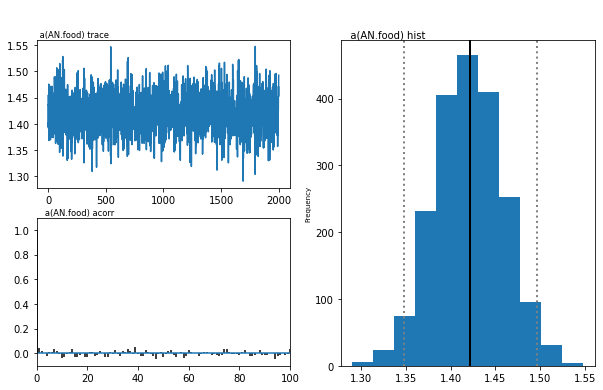

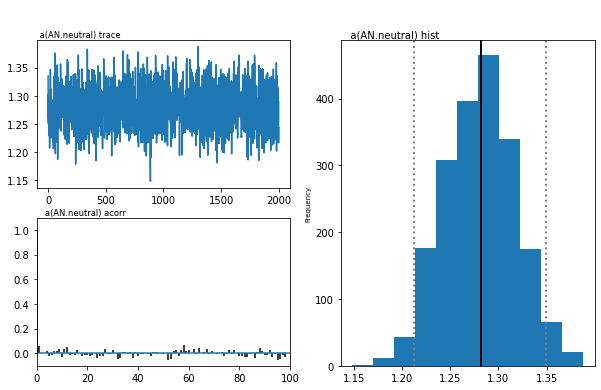

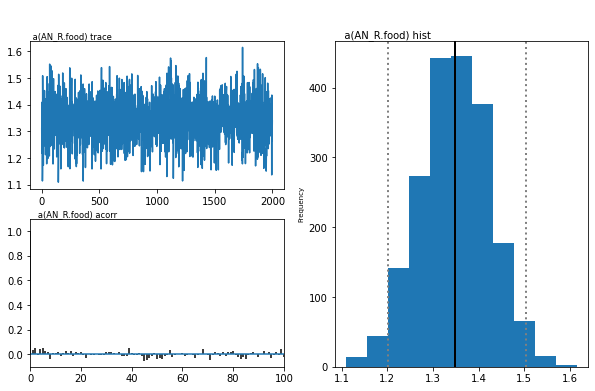

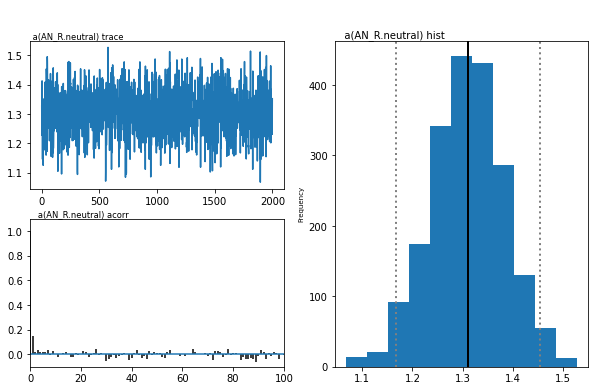

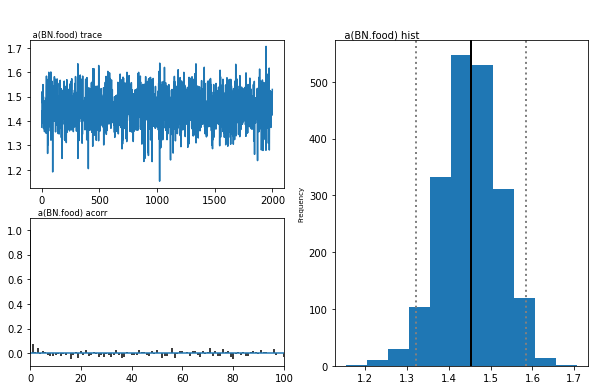

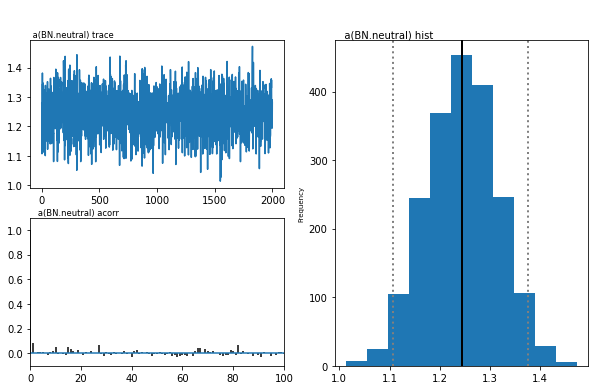

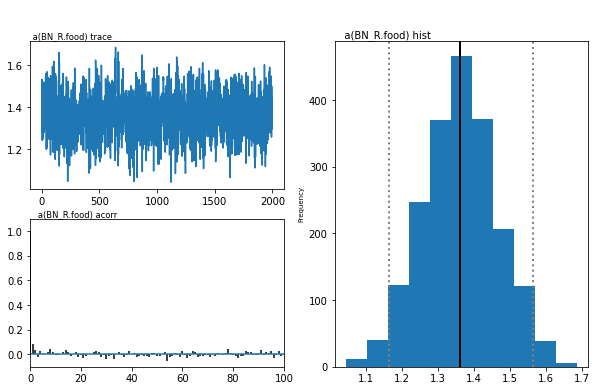

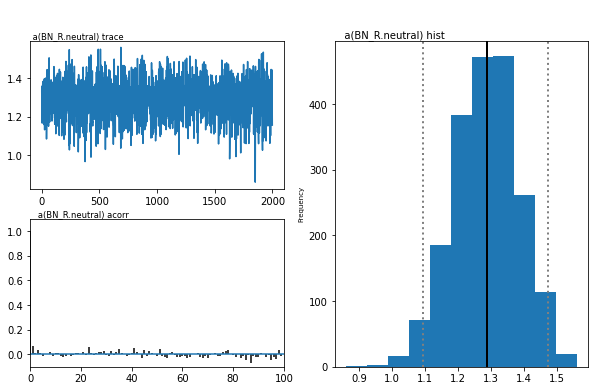

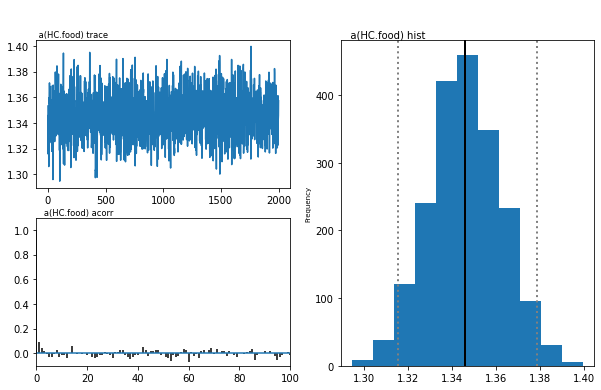

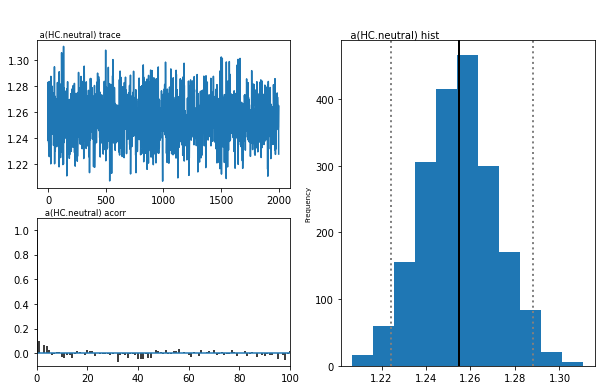

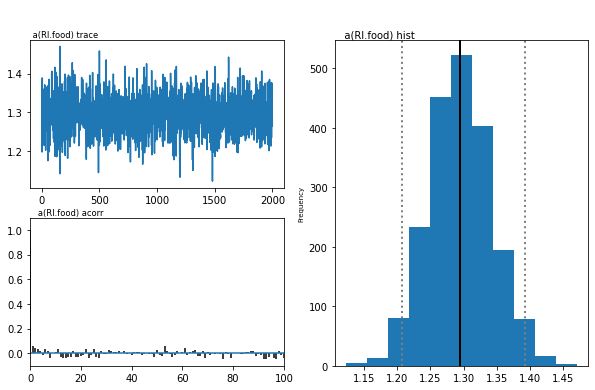

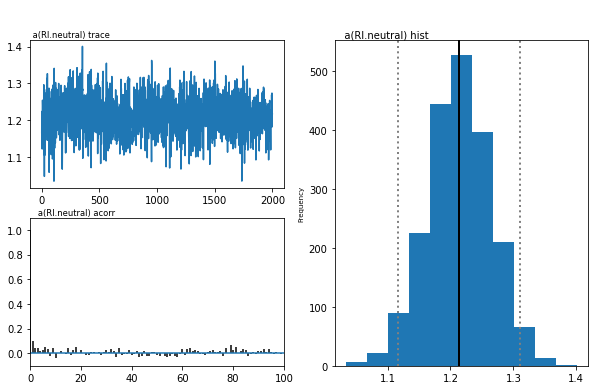

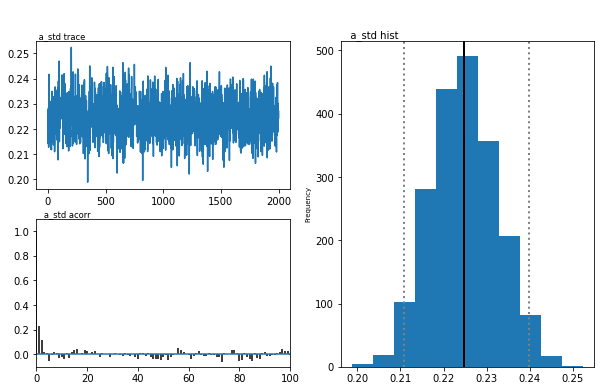

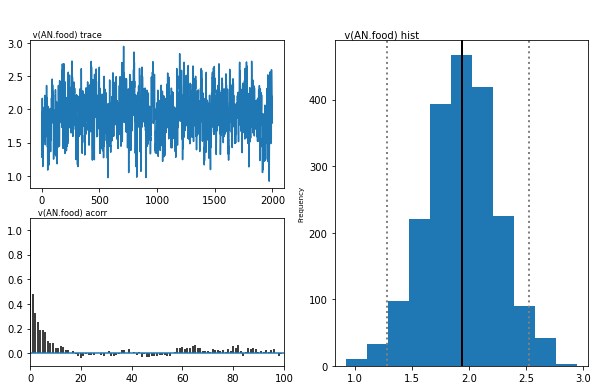

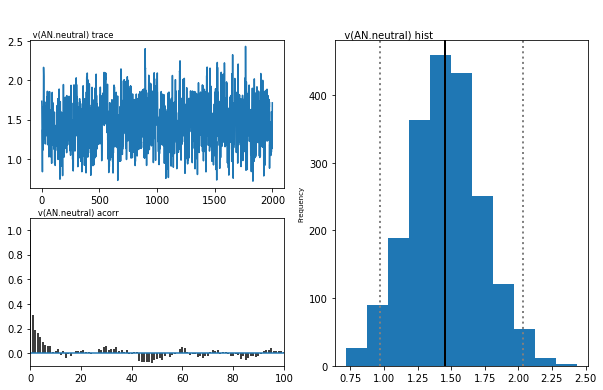

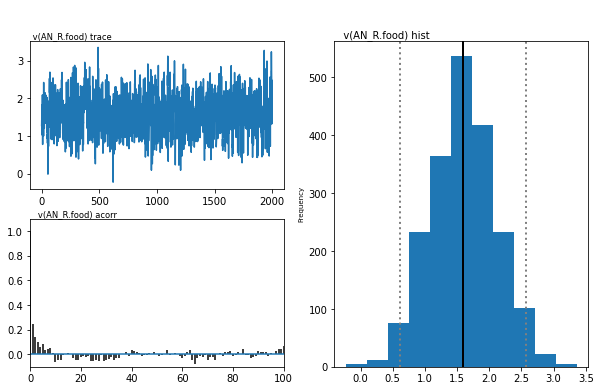

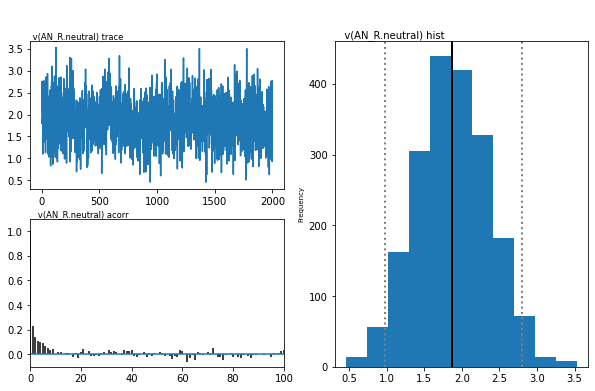

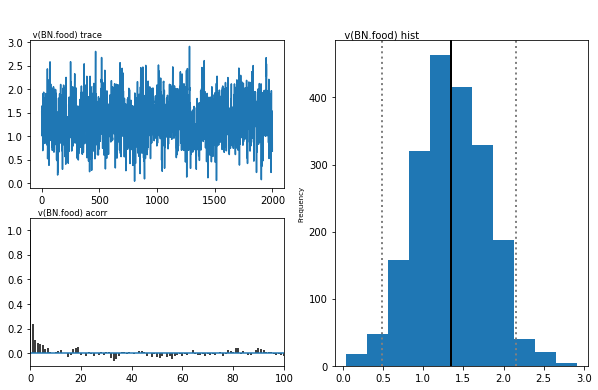

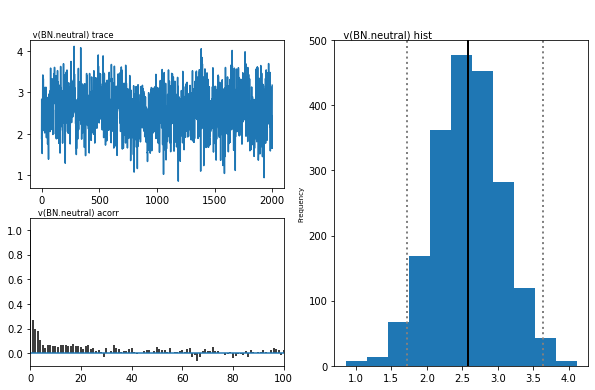

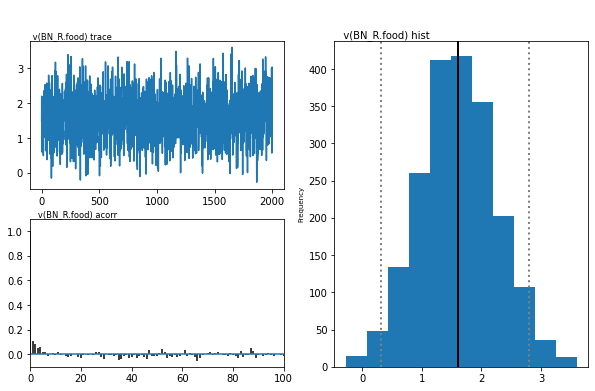

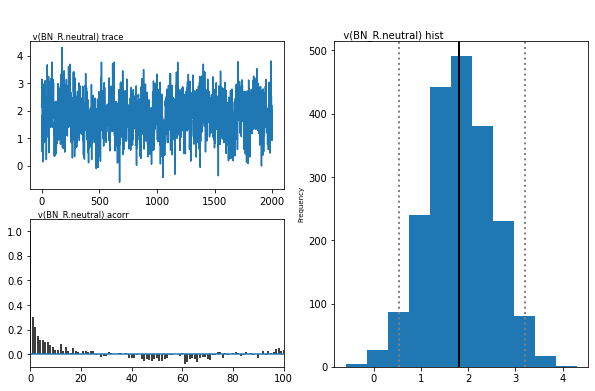

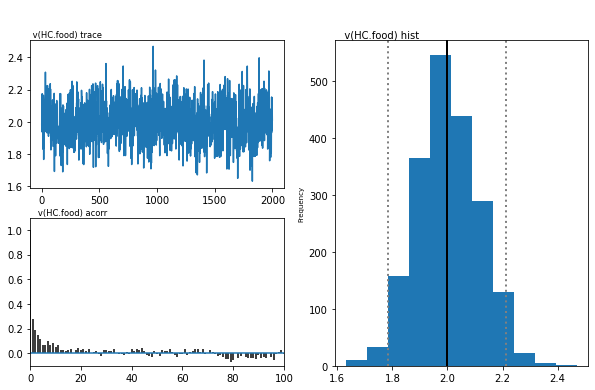

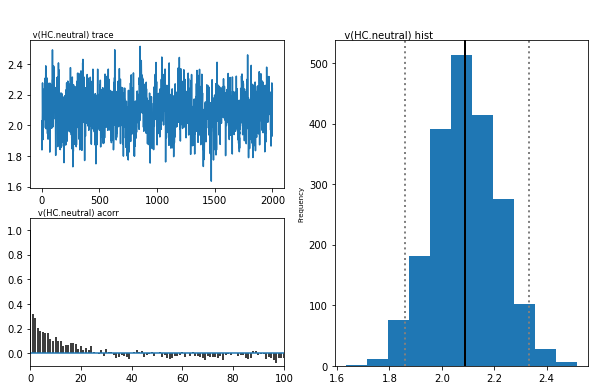

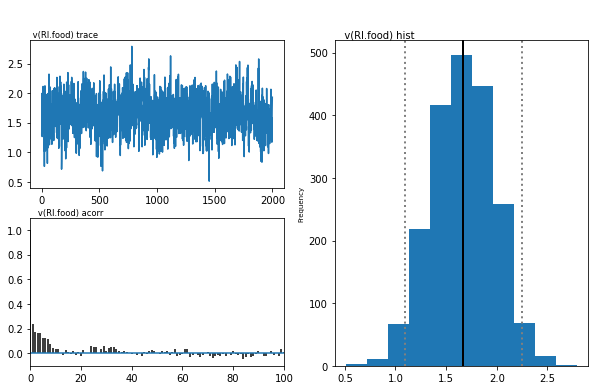

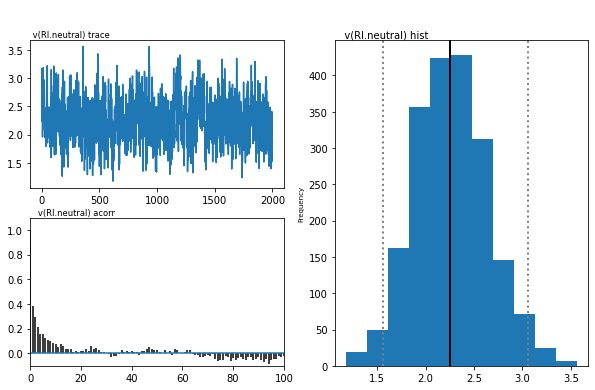

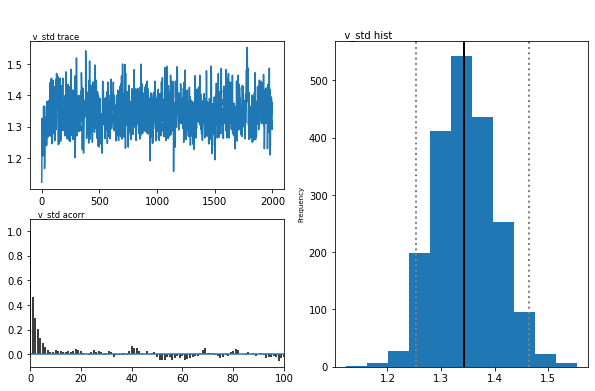

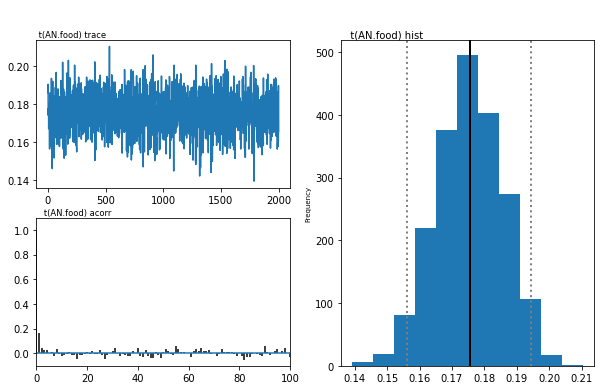

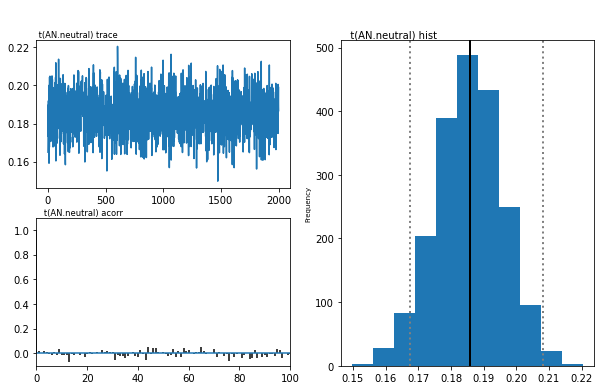

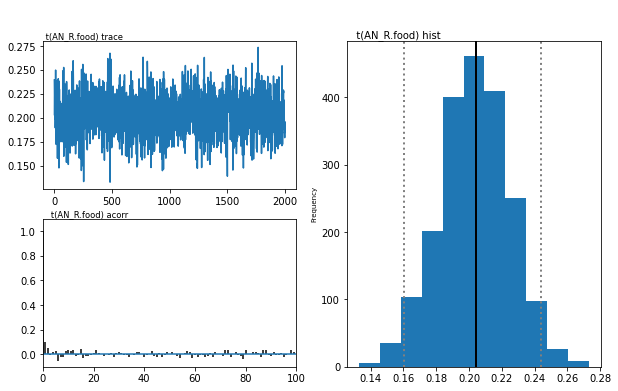

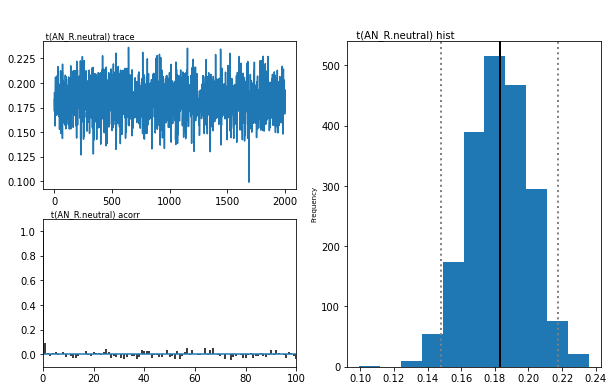

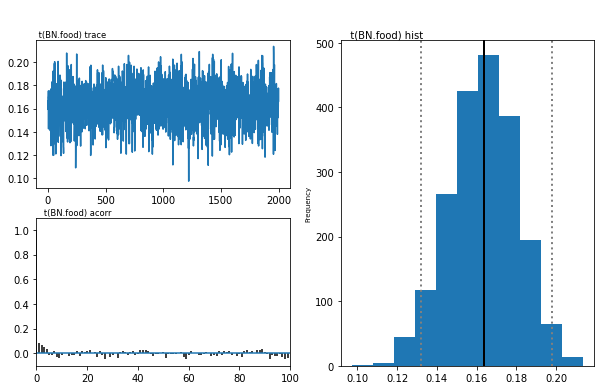

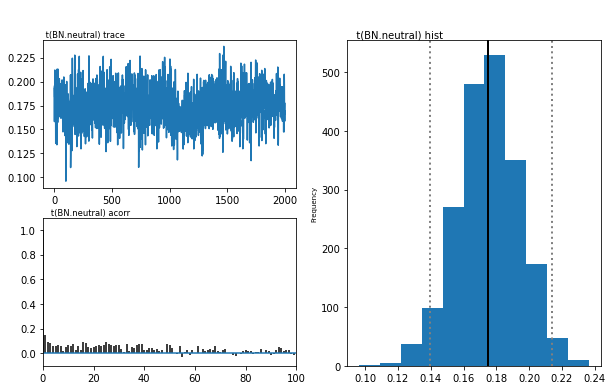

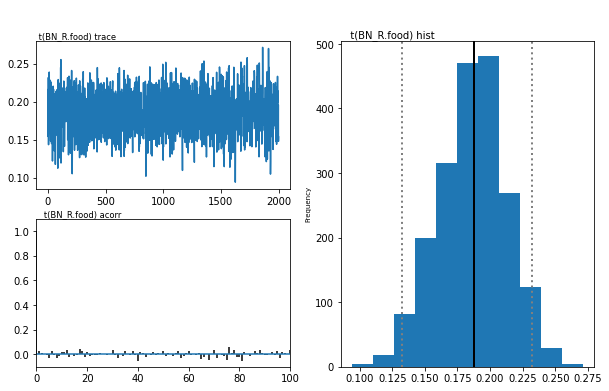

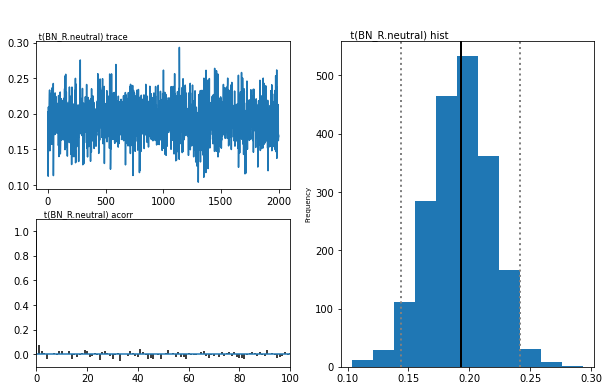

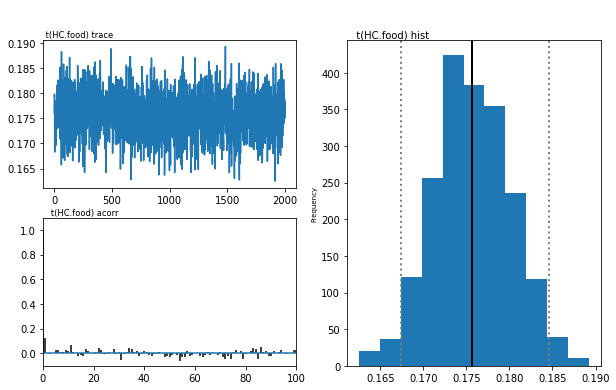

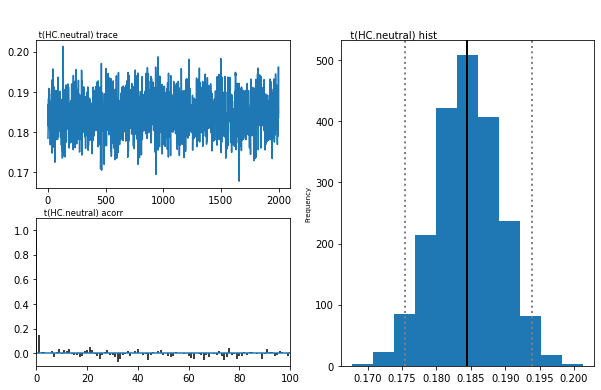

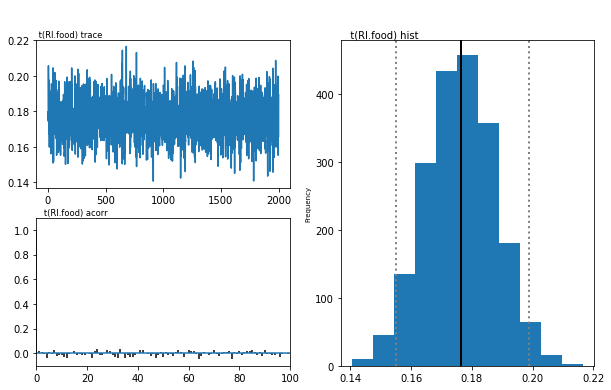

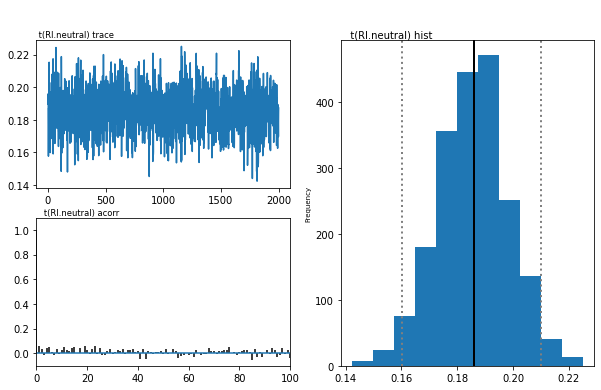

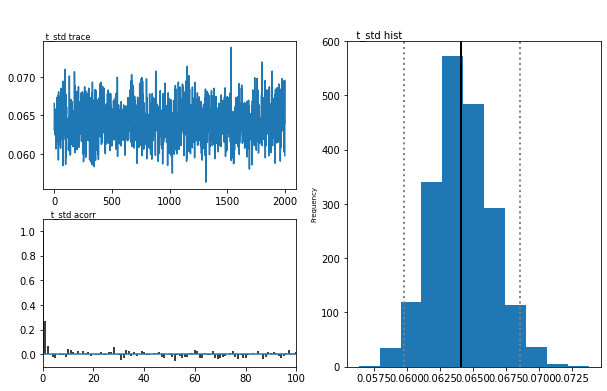

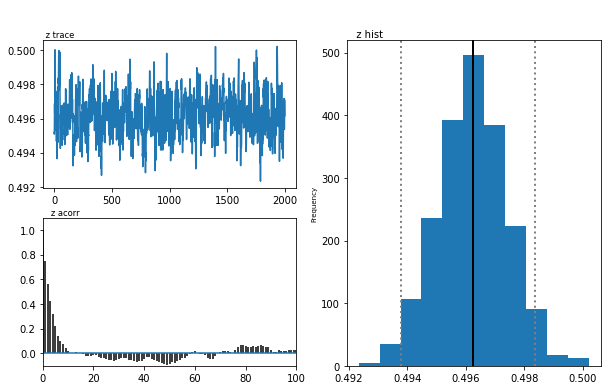

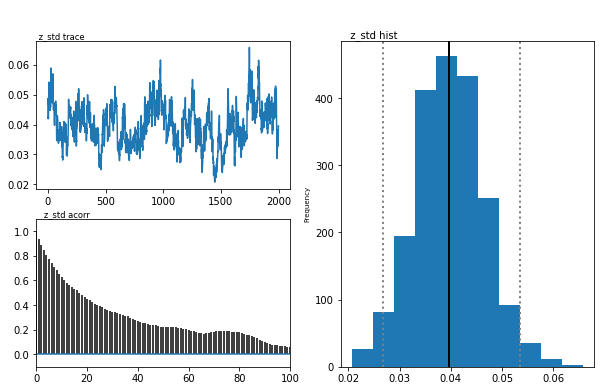

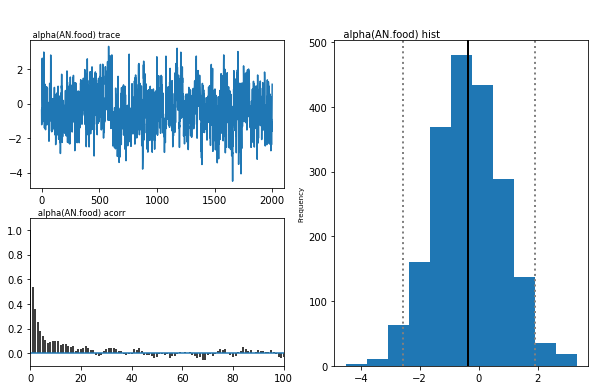

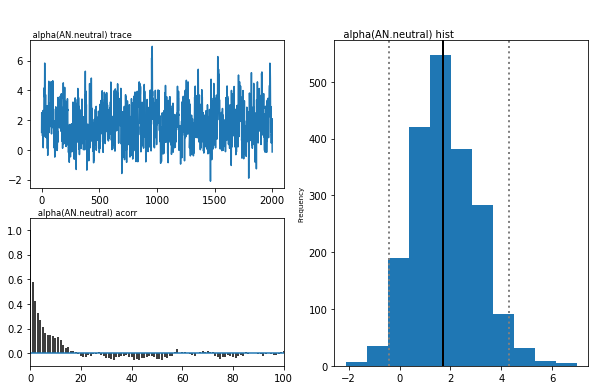

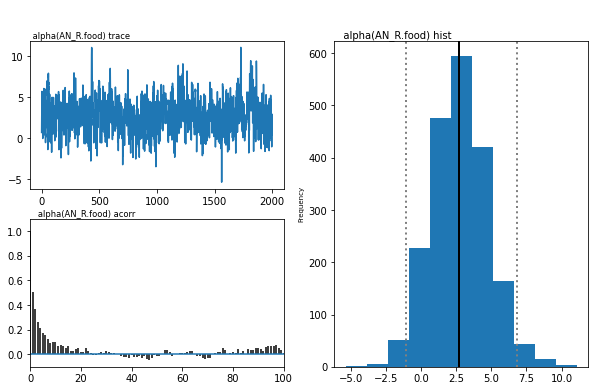

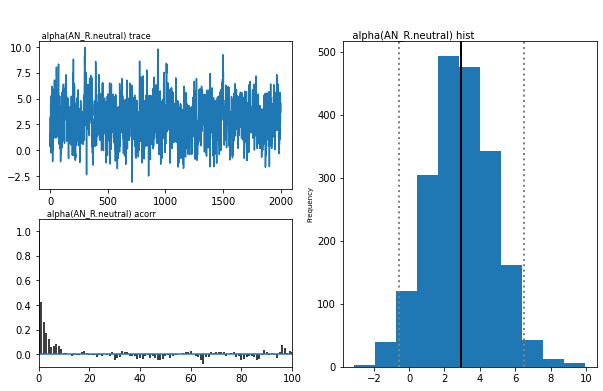

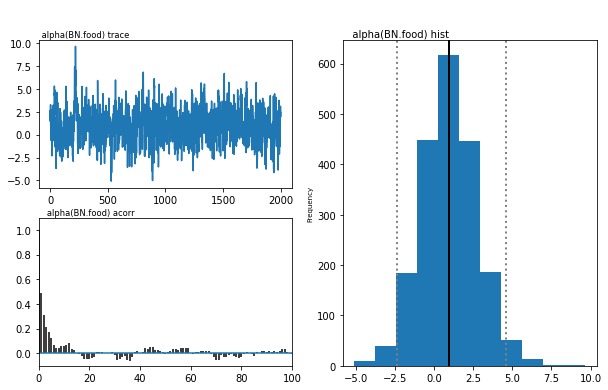

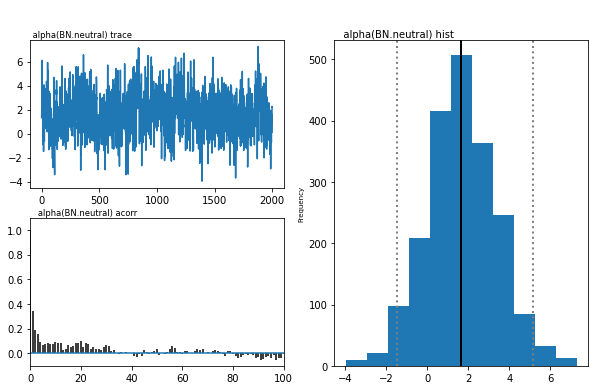

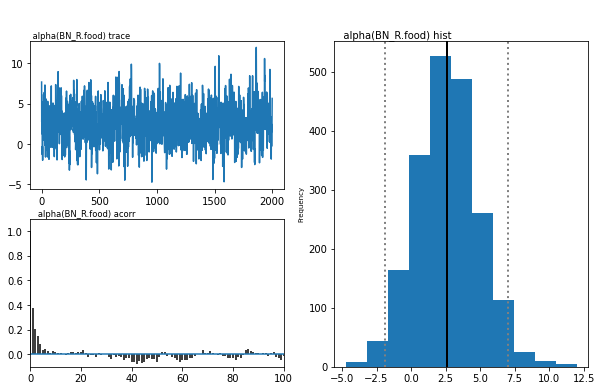

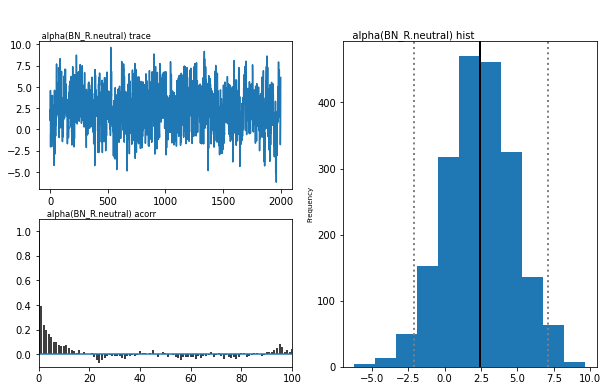

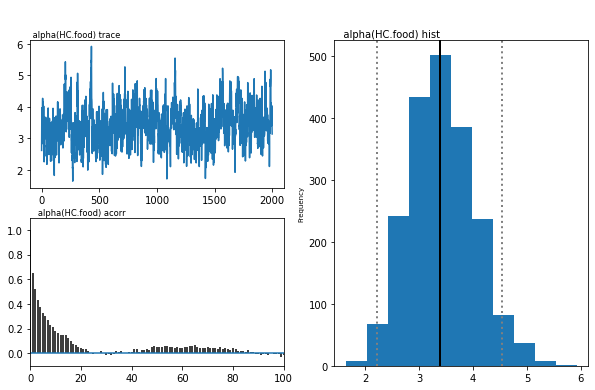

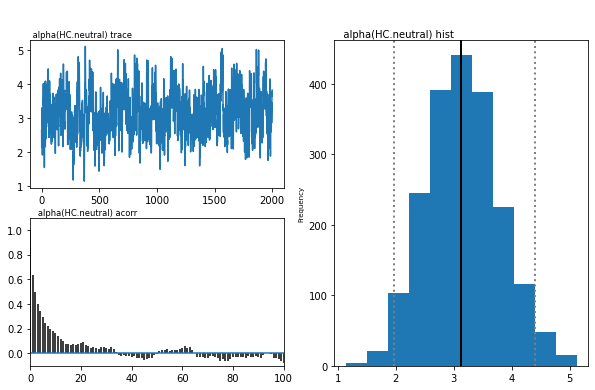

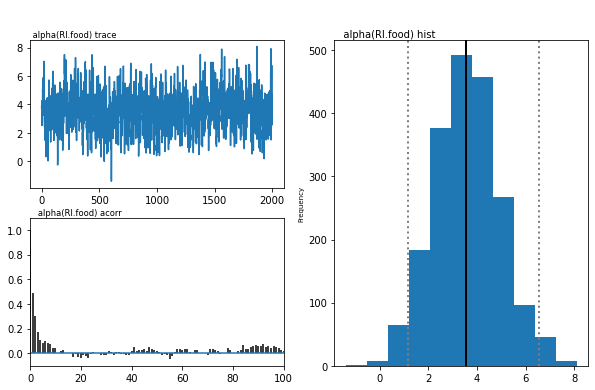

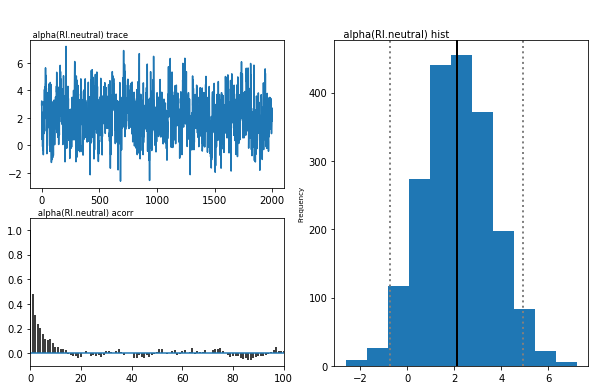

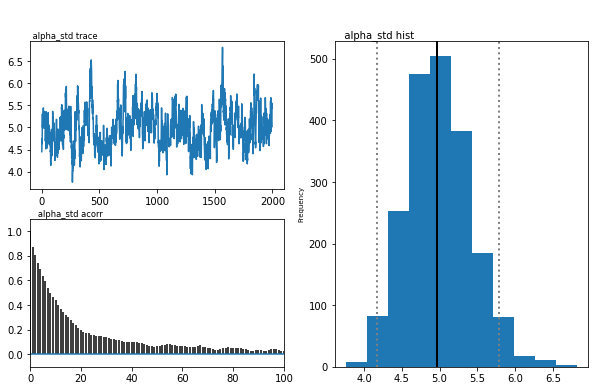

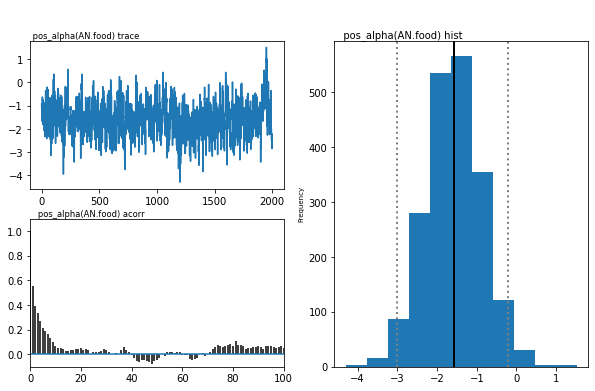

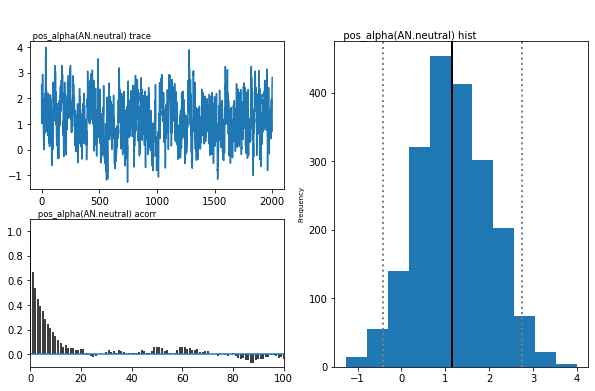

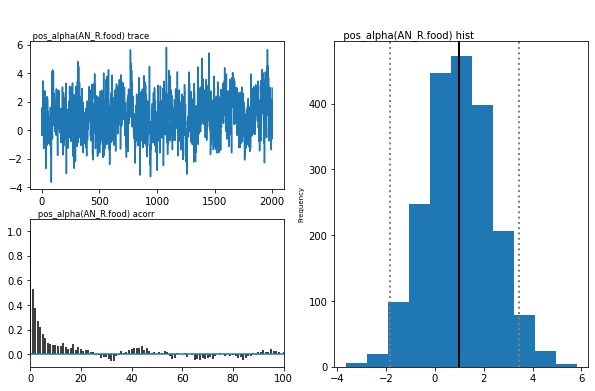

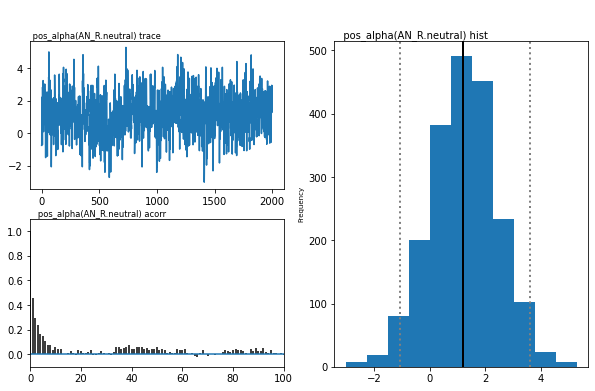

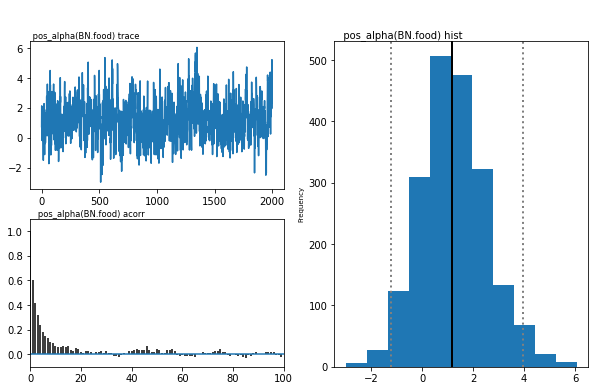

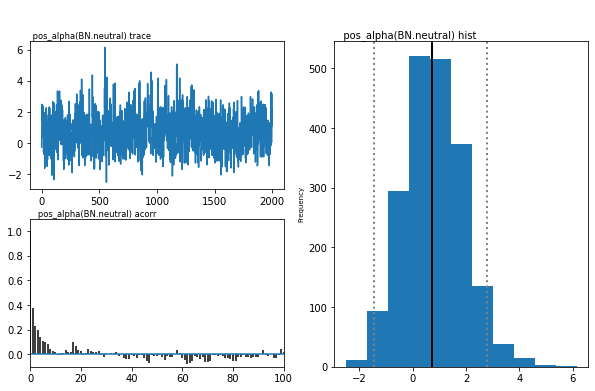

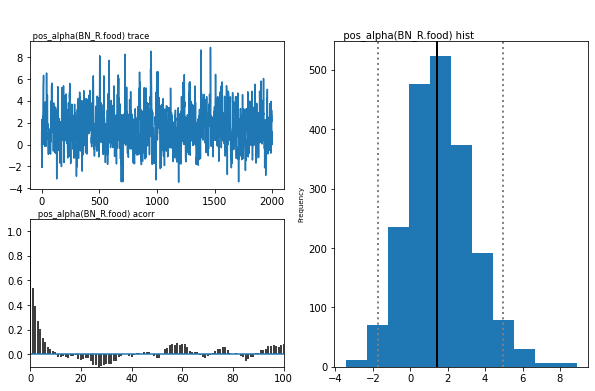

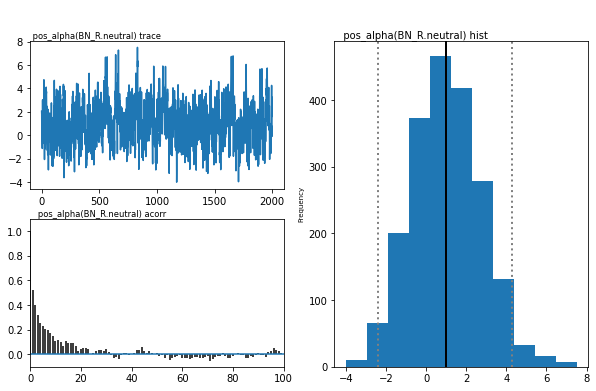

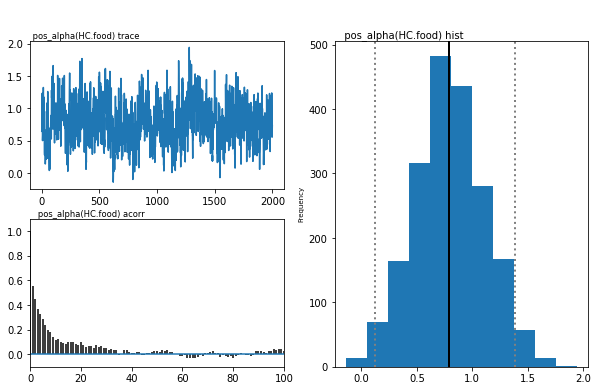

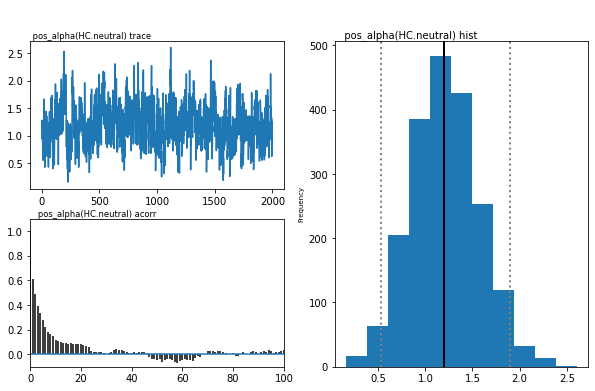

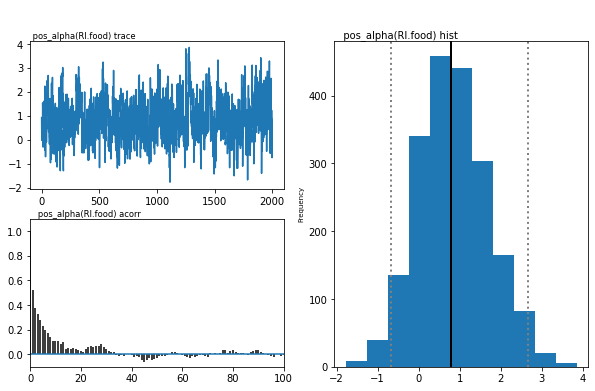

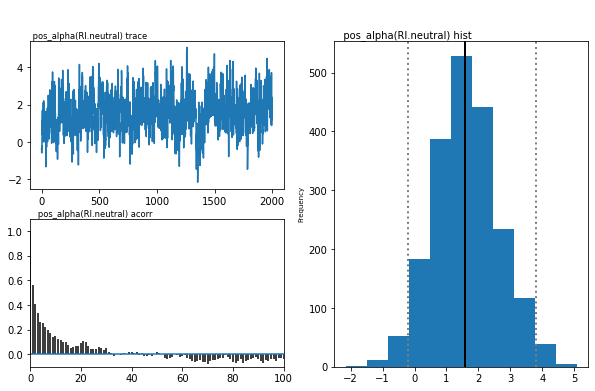

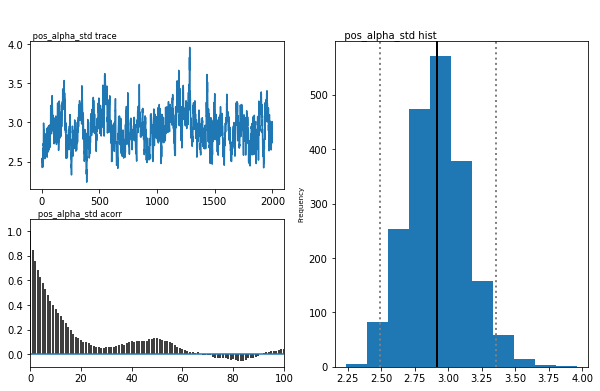

In [ ]:
mod1.plot_posteriors()

## Checking results

In [ ]:
# estimate convergence
from kabuki.analyze import gelman_rubin

In [ ]:
models = []
for i in range(3):
    m = hddm.HDDMrl(
        data,
        bias = True,
        depends_on = {
            'a':['stim'],
            'v':['stim'],
            'alpha':['stim'],
            'pos_alpha':['stim']
            },
        dual = True, 
        p_outlier = 0.05
    )
m.sample(1500, burn=500, dbname='traces.db', db='pickle')
models.append(m)

gelman_rubin(models)

In [ ]:
np.max(list(gelman_rubin(models).values()))

In [ ]:
# Combine the models we ran to test for convergence.
m = kabuki.utils.concat_models(models)

In [ ]:
alpha, t, a, v = m.nodes_db.node[['alpha', 't', 'a','v']]
samples = {'alpha':alpha.trace(),'t':t.trace(),'a':a.trace(),'v':v.trace()}
samp = pd.DataFrame(data=samples)

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(samp, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)
g.savefig('matrix_plot.png')

In [ ]:
from patsy import dmatrix

In [ ]:
data.head(10)

,subj_idx,response,stim,rt,trial,split_by,feedback,diag_cat,subj_code,q_init
0,1,0,food,0.681873,1,0,1,AN,ca_po_2002_05_25_700_f,0.5
1,1,0,neutral,0.683220,1,1,0,AN,ca_po_2002_05_25_700_f,0.5
2,1,1,food,1.939000,2,0,0,AN,ca_po_2002_05_25_700_f,0.5
3,1,1,neutral,0.350000,2,1,1,AN,ca_po_2002_05_25_700_f,0.5
4,1,0,food,0.768000,3,0,0,AN,ca_po_2002_05_25_700_f,0.5
5,1,1,neutral,0.717137,3,1,0,AN,ca_po_2002_05_25_700_f,0.5
6,1,0,food,1.271000,4,0,1,AN,ca_po_2002_05_25_700_f,0.5
7,1,0,neutral,0.412000,4,1,1,AN,ca_po_2002_05_25_700_f,0.5
8,1,1,food,1.929000,5,0,1,AN,ca_po_2002_05_25_700_f,0.5
9,1,1,neutral,0.181000,5,1,0,AN,ca_po_2002_05_25_700_f,0.5


In [ ]:
dmatrix("C(stim, Treatment('food'))", data.head(10))

DesignMatrix with shape (10, 2)
  Intercept  C(stim, Treatment('food'))[T.neutral]
          1                                      0
          1                                      1
          1                                      0
          1                                      1
          1                                      0
          1                                      1
          1                                      0
          1                                      1
          1                                      0
          1                                      1
  Terms:
    'Intercept' (column 0)
    "C(stim, Treatment('food'))" (column 1)

In [ ]:
# HDDMrlRegressor
# m_within_subj : NotImplementedError: Missing columns in design matrix. 
# You need data for all conditions for all subjects.

m_within_subj = hddm.HDDMrlRegressor(
  data,
  "alpha ~ C(stim, Treatment('food'))",
  bias = True,
  depends_on = {
      'a':['diag_cat'],
      'v':['diag_cat'],
      't':['diag_cat'],
      'alpha':['diag_cat'],
      'pos_alpha':['diag_cat']
     },
     include = "alpha"
)


Adding these covariates:
['alpha_Intercept', "alpha_C(stim, Treatment('food'))[T.neutral]"]
No model attribute --> setting up standard HDDM
Set model to ddm


NotImplementedError: ignored